# Presentation on Word2Vec

--- 
Glenn Abastillas | 24 March, 2020

<link rel="stylesheet" href="./css/style.css" type="text/css" />
<img src="./images/splash_image.png" style="height: 50%; width: 50%; float: right; margin-left: 2em;" />

This notebook goes over an example implementation of Word2Vec and some existing packages that perform Word2Vec training.

### Contents
  1.  Preliminary Steps
      * [Load Packages](#load_packages)
      * [Preprocess Data](#preprocess_data)
      * [Quick Background](#quick_background)
  2. [Implementation from Scratch](#implementation_from_scratch)
      * Word2Vec Flavors: Continuous Back of Words (CBOW) / Skip Grams (SG)
      * Training
      * Retrieving the trained matrix
      * Applications
  3. Using an Existing Package

---

## <span class='level-2'>1.0</span> Load Packages <a id="load_packages"></a>
First we import packages and clean the data.

In [6]:
import numpy as np
import spacy
from tqdm.notebook import trange, tqdm

import pandas as pd
import altair as alt
import matplotlib.pyplot as plt

from string import punctuation
from nltk.corpus import brown, gutenberg, stopwords
from collections import namedtuple
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from IPython.core.display import HTML

HTML('./style/style.html')
alt.renderers.enable('notebook')
corpus = brown

We will use data from the `gutenberg` corpus and normalize the input data.

In [2]:
title = 'cp01'
sents = corpus.sents(title)
words = corpus.words(title)

print(f'Number of sentences: {len(sents):,}')
print(f'Number of words: {len(words):,}')

Number of sentences: 131
Number of words: 2,332


<p class='tips banner'>Parameters, Counts, and Probability Data for Later</p>

In [3]:
sents = [[word.lower() for word in sent] for sent in sents]
words = [word.lower() for word in words]

WORDS, COUNTS = np.unique(words, return_counts=True)

PROBS = COUNTS**0.75 / (COUNTS**0.75).sum()

INDEX = np.arange(WORDS.size)

VOCAB = dict(zip(WORDS, INDEX))
VOCABR = dict(zip(INDEX, WORDS))

---
### 1.1 Visual Inspection

A quick look into our corpus reveals that a handful of sentence lengths dominate this text.

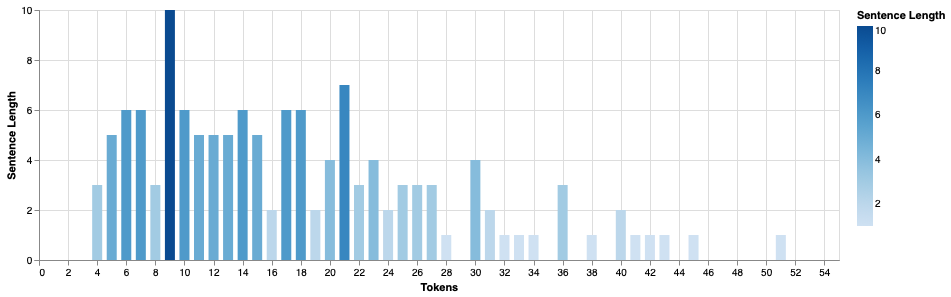

In [4]:
lengths = [len(sent) for sent in sents]
lengths = pd.DataFrame(lengths, columns=['tokens'])
lengths = lengths['tokens'].value_counts()
lengths = pd.DataFrame(lengths.reset_index())
lengths.columns = ['tokens', 'length']

# Visual look at the sentence lengths
chart = alt.Chart(lengths, width=800, height=250).mark_bar(size=10)
chart.encode(x=alt.X('tokens', title='Tokens'), 
             y=alt.Y('length', title='Sentence Length'),
             color=alt.Color('length', title='Sentence Length'))

`[insert navigation here]`

---

### 1.2 Preprocessing: Slimming Down

Next we preprocess the text to get rid of overly frequent words like stopwords. An example of stopwords are shown below. 

<img src='./images/stopwords.jpg'/>

This cell defines some functions to help us clean the input text of these types of words.

In [7]:
stopwords_ = stopwords.words('english')

def is_stopword(token):
    ''' Check if a specified token is a stopword. '''
    try:
        return token.lower() in stopwords_
    except:
        return False

def is_valid_token(token):
    ''' Check if token is valid, i.e., not a stopword or punctuation '''
    try:
        return token.isalnum() & ~is_stopword(token)
    except:
        return False

def subsample(vocabulary, probs=PROBS, sample_rate=0.001):
    ''' Return the indices of words to be excluded '''
    p_keep = (np.sqrt(probs / sample_rate) + 1) * sample_rate / probs
    p_keep[p_keep >= 1] = 1
    return p_keep

`[insert navigation here]`

---

<img src="./images/subsample.png" style='float: left; height: 10em; margin-left: 1em; margin-right: 2em;'/>

### 1.3 Subsampling

Remove overly frequent words that may not contribute much to vector meanings (e.g., the). First, generate a list of frequent words with a low probability of keeping them.
That is,  $P_{keep}(w_i) < 75\%$

<p class='attention banner'>For more detail on subsampling, see <a href="http://arxiv.org/pdf/1310.4546.pdf" target='blank'>Mikolov, Sutskever, et al.</a> (2013).</p>

In [8]:
keep = subsample(WORDS)
exclude = [word for word in WORDS[keep < 0.75]]

# Apply exclude filter to sentences
sents = [[word for word in sent if (word not in exclude) and is_valid_token(word)] for sent in sents]
print(f'Number of sentences: {len(sents):,}')

Number of sentences: 131


<img src="./images/matrix.png" style="float: right; height: 7em; margin-top: 2em; margin-right: 5em;" />

### 1.4 Encode Words to Integers

Using the conversion function defined above, we can convert our `normalized_sents` into `data`, which contains only integers that will be used in our Word2Vec example.

In [10]:
%%time
data = (np.array([VOCAB[token] for token in sent]) for sent in sents)

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 9.3 µs


<p class='tip banner'>Preprocessing complete! Now on to the model. </p>

`[insert navigation here]`

---

## 2.0 Word2Vec <a id='section-2'></a>

<h1> Quick Background</h1> <a id="quick_background"></a>

<img src="./images/splash_image_2.png" style="float: right; height: 40%; width: 40%; margin-left: 2em;" />

<h3> Word2Vec—What is it?</h3>
<p class='content'><span class='bold'>Word2Vec</span> is a method of representing words as numerical vectors. This representation allows us to improve model efficiency and endows words with numeric properties that capture semantic relationships in text like the image to the right.</p>
<p class='content'>That means that we convert words built from characters to 'words' built from numbers.</p>
<p class='example'>$word \Rightarrow [0.1,0.7,0.3,0.9,0.3]$</p>
<p class='example'>$bird \Rightarrow [0.1,0.7,0.8,0.7,0.5]$</p>

---

<h3> What are its uses?</h3>
<p class='content'>Because of <span class='bold'>Word2Vec</span>'s uncanny ability to capture hidden patterns in large corpora, <span class='bold'>Word2Vec</span> has many uses for information extraction from a large, unknown text. 
    Here's a short list of applications of <span class='bold'>Word2Vec</span> in documents:</p>

  * Identifying emerging topics in large amounts of text
  * Identifying entities and relationships
  * Developing knowledge resources for other NLP work (e.g., semantic analyses)
 
---
<h3> Other Models</h3>
<p class='content'><span class='bold'>Word2Vec</span> is not the only way to represent lexical items as numeric vectors. Other methods include <span class='bold'>Global Vectors for Word Representation (GloVe)</span> and <span class='bold'>Text Frequency - Inverse Document Frequency (TF-IDF)</span>.</p>



`[insert navigation here]`

---

<img src='./images/from_scratch.jpg' style='height: 20em; float: left; padding-right: 3em;' />

### 2.1 Implementation from Scratch <a id="implementation_from_scratch"></a>

For things example, we will create a Word2Vec language model using the data we preprocessed above. In this section, we will develop a **<a id="skip-gram" style="text-decoration: none; cursor: help;" title="Using the a token to predict its surroundings">Skip-gram</a>** flavored Word2Vec model.

We will:
  * Create Skip-gram windows
  * Create preliminary <a id='one-hot' style='text-decoration: none; cursor: help;' title='A vector that is comprised of zeros and ones indicating absence or presence of a value'>one-hot vectors</a>


###### Parameters <a id='parameters'></a>
First we define some hyperparameters that we use for training. For more information on setting parameters, see [Proceedings of the 2014 Conference on Empirical Methods in Natural Language Processing](https://www.aclweb.org/anthology/D14-1162/).

In [11]:
parameters = {'window' : 3, 'dimensions' : 100, 'learning_rate' : 0.01, 'epochs' : 20}

<p class='attention banner'>Style this table later and move to before the cell</p>
This table quickly describes what each parameter does.

Parameters | Data Type | Description
--- | :-: | :--
`window` | `int` | The number of target tokens before and after a central token to include
`dimensions` | `int` | The number of dimensions in hidden layer. Dimensions greater than 300 have diminishing returns `[cite]`.
`learning_rate` | `float` | How quickly our model will correct itself
`epochs` | `int` | The number of rounds the model is trained

### 2.2 Creating the Training Data <a id="creating_the_training_data"></a>

We will generate loose <a id='one-hot' style='text-decoration: none; cursor: help;' title='A vector that is comprised of zeros and ones indicating absence or presence of a value'>one-hot vectors</a> that will serve as input and target data when training our model.

First we filter our data to ensure we have sufficient data to window.

In [12]:
%%time
data = [sent for sent in data if sent.size >= parameters['window'] + 1]

print(f'Number of sentences in data: {len(data)}')

Number of sentences in data: 95
CPU times: user 1.56 ms, sys: 1.64 ms, total: 3.2 ms
Wall time: 6.94 ms


Now, we generate our one hot vectors using the `VOCAB` as a model for our vector.

Let's define a few functions to help use generate these data.

In [17]:
Datum = namedtuple('Datum', 'target context'.split())

def one_hot(token, size=WORDS.size):
    ''' Convert an input token into an integer according to a specified reference '''
    vector = np.zeros((1, size))
    vector[0, token] = 1
    return vector

def generate_examples(data, examples=[], size=parameters['window_size']):
    ''' Create a example data with the structure [(context, targets), ...] '''
    sentences = tqdm(enumerate(data), desc='Generating examples', total=len(data))
    
    for i, sentence in sentences:
        
        for j, token in enumerate(sentence):
            before = max(j - size, 0)
            after = j + size
            skip = j + 1

            context = one_hot(sentence[j])
            targets = np.append(sentence[before:j], sentence[skip:after])
            
            _targets = []
        
            for target in targets:
                _targets.append(one_hot(target))
                
            examples.append((context, _targets))
    
    return examples


Loop through all the sentences to generate `target` and `context` data for training.
<p class='attention'>Processing time may vary </p>

In [18]:
examples = generate_examples(data)
print(f'{len(examples)} examples')


795 examples


`[insert navigation here]`

---

<p class='tip banner'>New Section</p>


### 2.3 Algorithm Architecture <a id='create_layers'></a>

These matrices will serve as the layers that surround our `word2vec` layer during training.

<img src='./images/architecture.png' style='height: 50%; width: 50%; margin-bottom; 2em;' />

This cell defines the weight matrices used by the model.

In [19]:
dimensions = parameters['dimensions']
size = WORDS.size

w1 = np.random.random((size, dimensions))
w2 = np.random.random((dimensions, size))

print(f'Dimensions\nWeights 1 {w1.shape}\nWeights 2 {w2.shape}')

Dimensions
Weights 1 (776, 100)
Weights 2 (100, 776)


`[insert navigation here]`

---
### 2.4 Forward and Backward Algorithms

The first part of a two part algorithm defining a <a id='learning-step' style='text-decoration: none; cursor: help;' title='A phase where training data are learned and errors are adjusted throughout the model'>learning step</a>. This algorithm introduces our randomly initialized model to its first evidence of real data to learn from. It then predicts a surrounding vocabulary item from it.

In [20]:
def forward(context, targets, w1=w1, w2=w2):
    ''' Return three matrices corresponding to the prediction, hidden layer, and output '''
    hidden = context @ w1
    output = hidden @ w2
    prediction = softmax(output)
    error = calculate_error(prediction, targets)
    return prediction, error, output, hidden

def backpropagate(error, hidden, context, w1=w1, w2=w2):
    ''' Update weight matrices according to output from forward() '''
    w2_delta = np.outer(hidden, error) * parameters['learning_rate']
    hidden_error = error @ w2.T
    w1_delta = np.outer(context, hidden_error) * parameters['learning_rate']
    
    w1 -= w1_delta
    w2 -= w2_delta

#### 2.4.1 Supporting Functions for Forward and Backpropagate

In [21]:
def softmax(output):
    ''' Return the an array normalized to a probability '''
    e = np.exp(output)
    return e / e.sum()

def calculate_error(prediction, targets):
    ''' Return weights with the summed prediction error '''
    error = [prediction - token for token in targets]
    return np.sum(error, axis=0)

def calculate_loss(output, targets):
    ''' Calculate the cross entropy loss for an output of a forward pass '''
    right = len(targets) * np.log(np.sum(np.exp(output)))
    left = np.sum([output[target == 1] for target in targets])
    return -left + right

def cross_entropy(context, prediction):
    sum_ = np.sum(context * np.log(prediction))
    return -sum_ / context.size

`[insert navigation here]`

---
### 2.5 Training Algorithm

Having both the feed forward and backpropagation algorithms defined, we can now define a training algorithm to learn all training examples for a single <a id='epoch' style='text-decoration: none; cursor: help;' title='A complete cycle of learning steps through all training data'>epoch</a>.

In [22]:
def train(examples, w1=w1, w2=w2, parameters=parameters, total=WORDS.size):
    ''' Train the Word2Vec model on our training data to generate meaningful word vectors '''
    
    epochs = trange(parameters['epochs'], desc="Training")
    total_loss = []
    current_loss = 0
    predictions = []

    for epoch in epochs:
        data = tqdm(examples, desc=f'Epoch {epoch} — Previous Loss {round(current_loss, 1)}', leave=False)
        current_loss = 0
        for context, targets in data:
            prediction, error, output, hidden = forward(context, targets)
            backpropagate(error, hidden, context)
            current_loss += calculate_loss(context, prediction)
        total_loss.append(current_loss)
    return total_loss

`[insert navigation here]`

---
###### 2.5.1 Run Training <a id='test_iteration'></a>

This cell loops through all our training data to demonstrate what happens in one training <a id='epoch' style='text-decoration: none; cursor: help;' title='A complete cycle of learning steps through all training data'>epoch</a>.

<p class='warning banner'>Processing time may vary</p>

In [23]:
%%time
total_loss = train(examples)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 776

### Loss by Epoch

In [ ]:
total_loss = pd.DataFrame(total_loss, columns=['loss']).reset_index()

chart = alt.Chart(total_loss, width=800).mark_line()
chart.encode(y=alt.Y('loss:Q', title='Loss'), x=alt.X('index:O', title='Epoch'))

<p class='tip banner'>Save model with today's date YYYY-MM-DD</p>

In [ ]:
# from datetime import datetime
# np.save(f'{datetime.today():%Y%m%d}-model.csv', weights_1)

`[insert navigation here]`

---

## 3.0 Looking at Some Examples

We define some functions to inspect the output of our model.

In [ ]:
def word_vector(token, model=w1):
    ''' Return the word vector corresponding to a token '''
    return model[token]

def similarity(vector1, vector2):
    ''' Return the cosine similarity score for two tokens input as vectors '''
    if isinstance(vector1, str):
        vector1 = VOCAB[vector1]

    if isinstance(vector2, str):
        vector2 = VOCAB[vector2]
    
    if isinstance(vector1, int):
        vector1 = word_vector(vector1)
        
    if isinstance(vector2, int):
        vector2 = word_vector(vector2)
        
    a = np.dot(vector1, vector2)
    b = np.dot(vector1, vector1)
    c = np.dot(vector2, vector2)
    return a / (np.sqrt(b) * np.sqrt(c))

We inspect randomly selected words for their similarity score where $similarity \in [-1,1]$

In [ ]:
v1 = np.random.randint(0, WORDS.size)
v2 = np.random.randint(0, WORDS.size)
print(f'{VOCABR[v1]} and {VOCABR[v2]}')
similarity(v1, v2)

In [ ]:
similarity(392, 393)

Test the current model trained only on a single epoch.

In [ ]:
token = np.random.randint(0, WORDS.size)
a, b = w1[token - 1], w1[token]
distance = np.dot(a,b) / (np.sqrt(np.dot(a, a)) * np.sqrt(np.dot(b,b)))

print(f'Token number {token} is "{VOCABR[token]}" along with "{VOCABR[token-1]}" with cos score as {distance}')

In [ ]:
# np.savetxt('20200326_blake-poems.csv', weights_1, delimiter=',')

`[insert navigation here]`

---
#### Using Our Trained Model

We can use our trained model to `list things we can do with our Word2Vec model from earlier`.

First, we define functions to help do those things.

Test with algebraic interactions of this 

`[insert navigation here]`

---

## 4.0 Visualize Word2Vec <a id='section-4'></a>

We can visualize our word vectors trained using plotting packages like `matplotlib`, `seaborn`, and others. I make use of the `altair` visualization package.

<p class='tip'>Preprocessing</p>

### 4.1 Run Dimensionality Reduction Models

In [ ]:
pca2 = PCA(n_components=2)
pca50 = PCA(n_components=min(50, w1.shape[0]))
tsne = TSNE(n_components=2, perplexity=100)
scale = StandardScaler()

Normalize the vector weights so that $\mu = 0$ and $\sigma = 1$.

In [ ]:
scaled_data = scale.fit_transform(w1)

Reduce dimensionality via PCA transform.

In [ ]:
pca_data_2 = pca2.fit_transform(scaled_data)
pca_data_50 = pca50.fit_transform(scaled_data)

Reduce dimensionality via TSNE transform.

<p class='warning'> Results may vary from run to run</p>

In [ ]:
%%time
tsne_data = tsne.fit_transform(pca_data_50)

In [ ]:
plt.scatter(x=tsne_data[:,0], y=tsne_data[:,1])

In [ ]:
plt.scatter(x=pca_data_2[:,0], y=pca_data_2[:,1])

### 4.2 Visualize Words in Vector Space

After transforming the high-dimensional data down to 2 and 3 dimensional datasets, we can better visualize what the vectors we trained look like.

In [ ]:
current = tsne_data
columns = [f'd{i}' for i in range(current.shape[-1])]
index = [f'{VOCABR[i]}' for i in range(current.shape[0])]

viz_data = pd.DataFrame(tsne_data, columns=columns, index=index).reset_index()

In [ ]:
chart = alt.Chart(viz_data)

In [ ]:
marked = chart.mark_point()
marked.encode(x=alt.X('d1:Q', title='Dimension'), y='d0:Q', tooltip='index').interactive(True)

In [ ]:
corpus.sents(title)

In [ ]:
viz_data

---

In [ ]:
vector.shape, matrix_1.shape

In [ ]:
pred, h, u = forward(vector, matrix_1, matrix_2)
pred.shape, h.shape, u.shape

In [ ]:
VOCABR[vector.argmax()]

In [ ]:
VOCABR[pred.argmax()]

## 5.0 Using an Existing Package <a id='section-5'></a>

There are existing implementations that already exist that allow you to use Word2Vec technology out of the box.

Examples of these include:
  * SpaCy
  * gensim
  * ELMo
  * fasttext
 
<img src='./images/man_woman.jpg' style='height: 35em;'/>

---

References
[1] Test

---